In [27]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.double)

from botorch.utils.transforms import normalize

from activephasemap.models.np import NeuralProcess
from activephasemap.models.mtgp import MultiTaskGPVersion2 as GP
from activephasemap.utils.simulators import UVVisExperiment
from activephasemap.utils.settings import from_comp_to_spectrum
from botorch.utils.sampling import draw_sobol_samples

import json 

color_blindf = ["#1F77B4", "#AEC7E8", "#FF7F0E", "#FFBB78", 
                "#2CA02C", "#98DF8A", "#D62728", "#FF9896", 
                "#9467BD", "#C5B0D5", "#8C564B",  "#C49C94", 
                "#E377C2", "#F7B6D2", "#7F7F7F", "#C7C7C7", 
                "#BCBD22", "#DBDB8D", "#17BECF", "#9EDAE5"
                ]

pyplot_style ={"text.usetex": True,
               "text.latex.preamble": r"\usepackage{amsfonts}\usepackage[version=4]{mhchem}",
               "axes.spines.right" : False,
               "axes.spines.top" : False,
               "font.size": 18,
               "savefig.dpi": 600,
               "savefig.bbox": 'tight',
              } 

In [28]:
ITERATION = 8
SAVE_FIGS = False
DATA_DIR = "./"
design_space_bounds = [(0.0, 87.0), (0.0,11.0)]

expt = UVVisExperiment(design_space_bounds, ITERATION, DATA_DIR+"/data/")
expt.generate(use_spline=True)

with open('../best_config.json') as f:
    best_np_config = json.load(f)
N_LATENT = best_np_config["z_dim"]

# Load trained GP model for p(z|c)
train_x = torch.load(DATA_DIR+'/output/train_x_%d.pt'%ITERATION, map_location=device)
train_y = torch.load(DATA_DIR+'/output/train_y_%d.pt'%ITERATION, map_location=device)
bounds = expt.bounds.to(device)
normalized_x = normalize(train_x, bounds).to(train_x)
gp_model = GP(normalized_x, train_y)
gp_state_dict = torch.load(DATA_DIR+'/output/gp_model_%d.pt'%(ITERATION), map_location=device)
gp_model.load_state_dict(gp_state_dict)

# Load trained NP model for p(y|z)
np_model = NeuralProcess(best_np_config["r_dim"], N_LATENT, best_np_config["h_dim"]).to(device)
np_model.load_state_dict(torch.load(DATA_DIR+'/output/np_model_%d.pt'%(ITERATION), map_location=device))

Loading data from iteration 0 with shapes: (24, 2) (24, 101)
Loading data from iteration 1 with shapes: (8, 2) (8, 101)
Loading data from iteration 2 with shapes: (8, 2) (8, 101)
Loading data from iteration 3 with shapes: (8, 2) (8, 101)
Loading data from iteration 4 with shapes: (8, 2) (8, 101)
Loading data from iteration 5 with shapes: (8, 2) (8, 101)
Loading data from iteration 6 with shapes: (8, 2) (8, 101)
Loading data from iteration 7 with shapes: (8, 2) (8, 101)


<All keys matched successfully>

In [29]:
grid_comps = np.load(DATA_DIR+"/grid/grid_comps.npy")
grid_spectra = np.load(DATA_DIR+"/grid/grid_spectra.npy")
print("Compositions shape: ", grid_comps.shape)
print("Spectra shape : ", grid_spectra.shape)

Compositions shape:  (2000, 2)
Spectra shape :  (2000, 100)


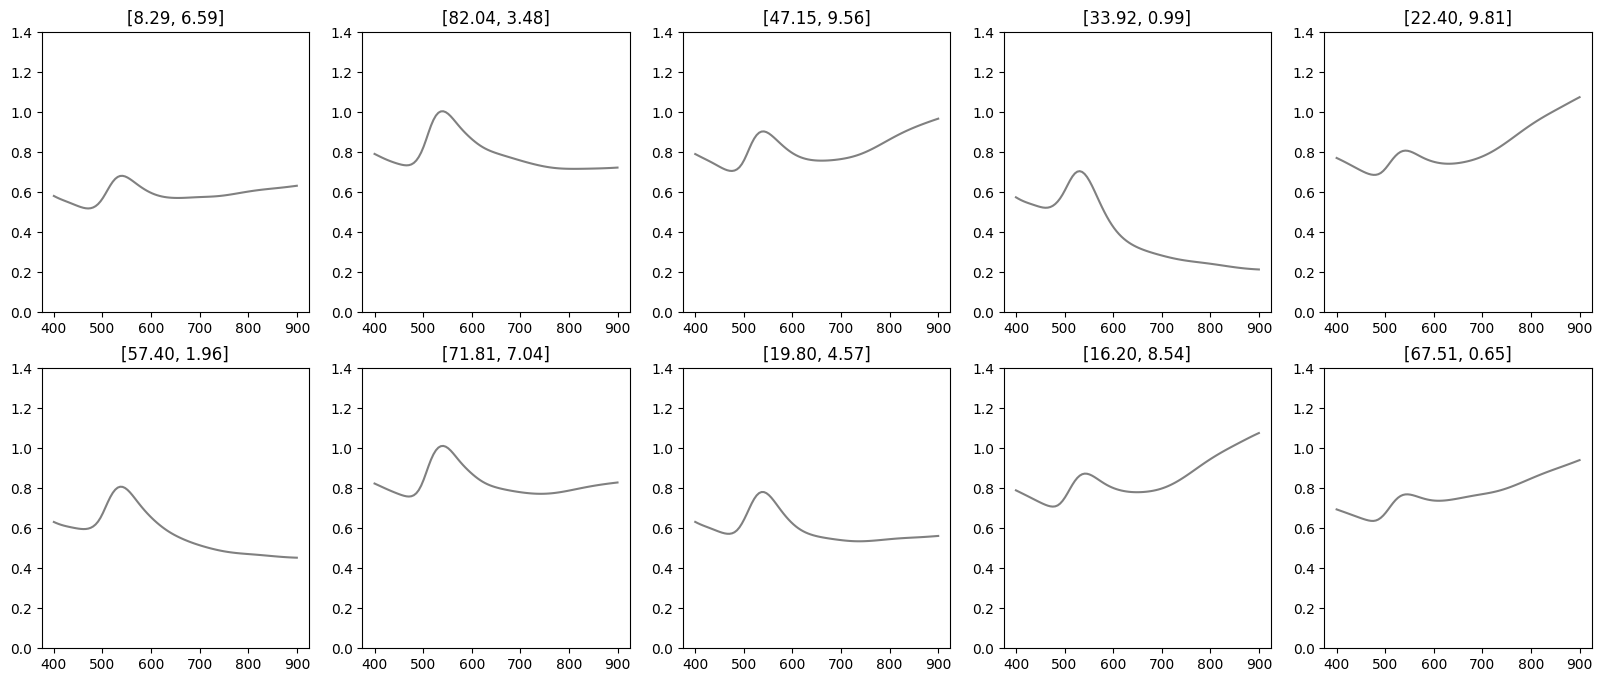

In [30]:
with torch.no_grad():
    fig, axs = plt.subplots(2,5,figsize=(4*5, 4*2))
    axs = axs.flatten()
    sampled_comps = draw_sobol_samples(bounds=bounds, n=10, q=1).squeeze().numpy()
    sampled_spectra = np.zeros((10, expt.n_domain))
    
    for i,ci in enumerate(sampled_comps):
        mu, _ = from_comp_to_spectrum(expt, 
                                      gp_model, 
                                      np_model, 
                                      ci.reshape(1, expt.dim)
                                      )
        sampled_spectra[i,:] = mu.cpu().squeeze()
        axs[i].plot(expt.wl, sampled_spectra[i,:], label="GP pred.", color="grey")
        axs[i].set_title("[%.2f, %.2f]"%(ci[0], ci[1]))
        axs[i].set_ylim([0.0,1.4])
    plt.show()

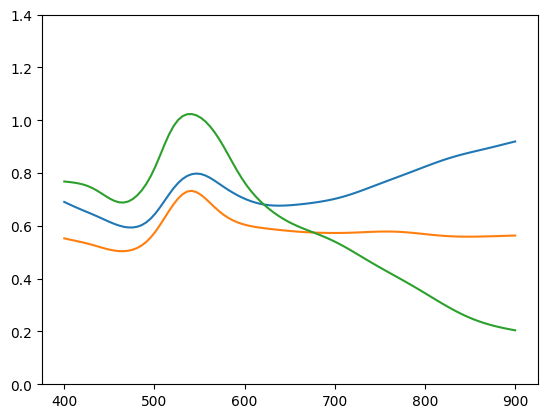

In [31]:
eta = np.load("templates.npy")
n_clusters = eta.shape[0]
fig, ax = plt.subplots()
for i in range(n_clusters):
    ax.plot(expt.wl, eta[i,:])
ax.set_ylim([0.0,1.4])
plt.show()

In [32]:
# get Euclidean distances instead
from scipy.spatial.distance import cdist
distances = cdist(grid_spectra, eta, metric='euclidean')
cluster_ids = distances.argmin(axis=1)

In [65]:
spheres = np.argwhere(np.less_equal(grid_spectra[:,-1], 0.4)).squeeze()
plates = np.argwhere(np.greater_equal(grid_spectra[:,-1], 0.65)).squeeze()
mix = np.setdiff1d(np.arange(grid_comps.shape[0]), np.union1d(spheres, plates))
cluster_ids = np.zeros(grid_comps.shape[0])
cluster_ids[spheres] =2 
cluster_ids[plates] =0
cluster_ids[mix] = 1

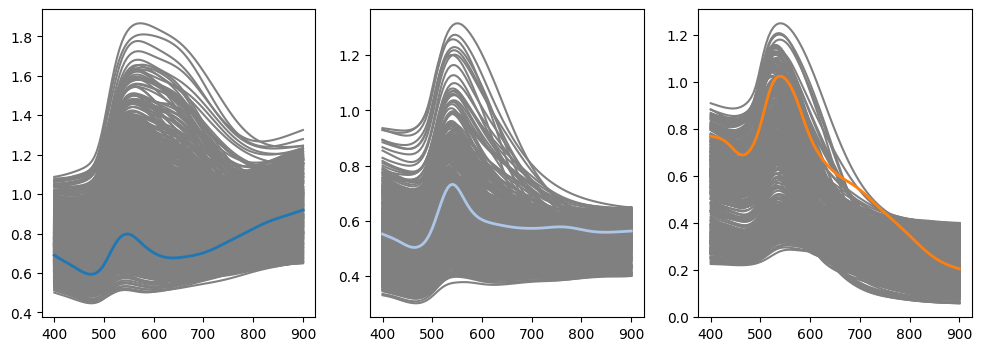

In [66]:
from matplotlib.colors import Normalize
from matplotlib import colormaps 

fig, axs = plt.subplots(1, n_clusters, figsize=(4*n_clusters, 4*1))
plot_all = True
for i, ax in enumerate(axs):
    rids = np.argwhere(cluster_ids==i).squeeze()
    clustered_spectra = grid_spectra[rids, :]
    for sij in clustered_spectra:
        ax.plot(expt.wl, sij, color="grey")
    ax.plot(expt.wl, eta[i], color=color_blindf[i], lw=2.0)

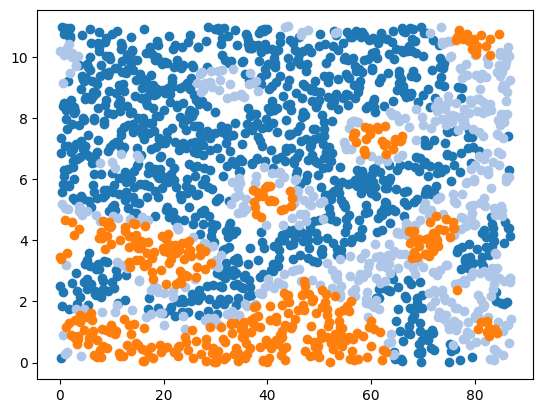

In [67]:
fig, ax = plt.subplots()
for i in range(n_clusters):
    ax.scatter(grid_comps[cluster_ids==i,0], 
               grid_comps[cluster_ids==i,1],
               color = color_blindf[i]
    )
plt.show()

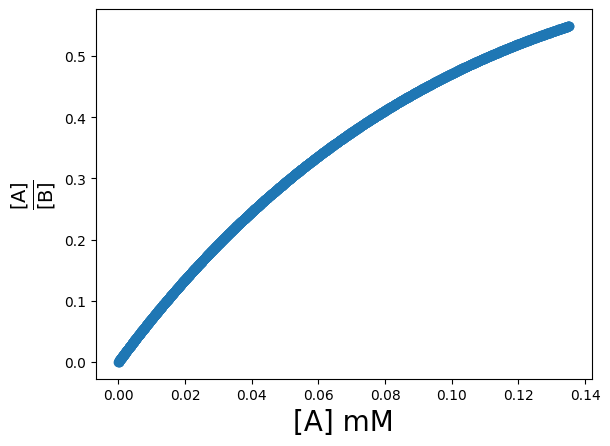

In [35]:
fixed_volumes = [54, 87, 13]
V_total = 280 
V_water = lambda x : 280-sum(fixed_volumes)-x 
z2m246i_vol_to_conc = lambda v : (0.3*87)/(v-87)
plot_mat = []
for ci in grid_comps:
    v_initial = V_total - ci[0]
    c_z2m246i = z2m246i_vol_to_conc(v_initial)
    c_z2 = (0.3*ci[0])/(280.0-ci[0])
    r = c_z2/c_z2m246i
    plot_mat.append([c_z2, c_z2m246i, r])

plot_mat = np.asarray(plot_mat)
fig, ax = plt.subplots()
ax.scatter(plot_mat[:,0], plot_mat[:,-1])
ax.set_xlabel("[A] mM", fontsize=20)
ax.set_ylabel(r"$\frac{[\mathrm{A}]}{[\mathrm{B}]}$", fontsize=20)
plt.show()

In [39]:
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from botorch.models.utils.gpytorch_modules import get_matern_kernel_with_gamma_prior

train_x = torch.Tensor(grid_comps)
train_y = torch.Tensor(cluster_ids).long().squeeze()

n_grid_points = 30
test_d1 = np.linspace(grid_comps[:,0].min(), grid_comps[:,0].max(), n_grid_points)
test_d2 = np.linspace(grid_comps[:,1].min(), grid_comps[:,1].max(), n_grid_points)
test_x_mat, test_y_mat = np.meshgrid(test_d1, test_d2)
test_x_mat, test_y_mat = torch.Tensor(test_x_mat), torch.Tensor(test_y_mat)

test_x = torch.cat((test_x_mat.view(-1,1), test_y_mat.view(-1,1)),dim=1)

class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = get_matern_kernel_with_gamma_prior(
            batch_shape=torch.Size((num_classes,)), 
            ard_num_dims=train_x.shape[-1]
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
# we let the DirichletClassificationLikelihood compute the targets for us
likelihood = DirichletClassificationLikelihood(train_y, learn_additional_noise=True)
model = DirichletGPModel(train_x, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes)

# Find optimal model hyperparameters
training_iter = 100
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, likelihood.transformed_targets).sum()
    loss.backward()
    if (i % 20 == 0) or (i==training_iter-1):
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.mean().item(),
            model.likelihood.second_noise_covar.noise.mean().item()
        ))
    optimizer.step()

model.eval()
likelihood.eval()

with gpytorch.settings.fast_pred_var(), torch.no_grad():
    test_dist = model(test_x)
    pred_means = test_dist.loc

pred_samples = test_dist.sample(torch.Size((256,))).exp()
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)

Iter 1/100 - Loss: 10.155   lengthscale: 0.693   noise: 0.693
Iter 21/100 - Loss: 6.494   lengthscale: 1.558   noise: 0.801
Iter 41/100 - Loss: 5.979   lengthscale: 1.929   noise: 0.225
Iter 61/100 - Loss: 5.836   lengthscale: 2.179   noise: 0.062
Iter 81/100 - Loss: 5.771   lengthscale: 2.289   noise: 0.032
Iter 100/100 - Loss: 5.735   lengthscale: 2.373   noise: 0.022


/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_1392/1770892207.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(conc_labels)


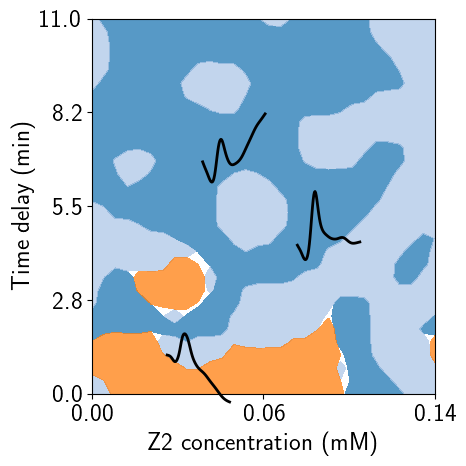

In [48]:
import matplotlib.ticker as ticker

def prettify_axis(ax):
    ax.set_xlabel('Z2 concentration (mM)')
    ax.set_ylabel('Time delay (min)') 
    ax.set_xlim(*design_space_bounds[0])
    ax.set_ylim(*design_space_bounds[1])
    ax.xaxis.set_major_locator(ticker.LinearLocator(3))
    ax.yaxis.set_major_locator(ticker.LinearLocator(5))
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    vol_labels = [item.get_text() for item in ax.get_xticklabels()]
    z2_vol_to_conc = lambda v : (0.3*v)/(280.0-v)
    conc_labels = []
    for l in vol_labels:
        conc_labels.append("%.2f"%z2_vol_to_conc(float(l)))
    ax.set_xticklabels(conc_labels)
    return ax

def plot_phasemap(ax):
    min_prob = 0.5
    for k in range(n_clusters):
        flags = probabilities[k]>min_prob
        comps_k_mean = np.median(test_x[flags,:], axis=0)
        norm_ci = (comps_k_mean-grid_comps.min(axis=0))/((grid_comps.max(axis=0)-grid_comps.min(axis=0)))
        loc_ax = ax.transLimits.transform(norm_ci)
        ins_ax = ax.inset_axes([loc_ax[0]-0.1,loc_ax[1]-0.1,0.2,0.2])
        ins_ax.plot(expt.wl, eta[k,:], color="k", lw=2.0)
        ins_ax.axis("off")

    for k in range(n_clusters):
        ax.contourf(test_x_mat.numpy(),
                    test_y_mat.numpy(),
                    probabilities[k].numpy().reshape((n_grid_points,n_grid_points)),
                    levels=[min_prob, 1.0],
                    colors=color_blindf[k],
                    alpha=0.75
                    )
    prettify_axis(ax)

    return 

with plt.style.context(pyplot_style):
    fig, ax = plt.subplots(figsize=(5,5))
    ax.spines[['right', 'top']].set_visible(True)
    plot_phasemap(ax)
    plt.tight_layout()
    if SAVE_FIGS:
        plt.savefig("./figures/phasemap_simple.png")
    plt.show()

In [40]:
points = np.asarray([[20.0, 1.0], [20.0, 6.0]])
number_of_points=10
xs=np.linspace(20.0, 20.0, number_of_points)
ys=np.linspace(1.0, 6.0, number_of_points)
line_comps = np.vstack((xs, ys)).T
with torch.no_grad():
    line_spectra = np.zeros((10, expt.n_domain))
    
    for i,ci in enumerate(line_comps):
        mu, _ = from_comp_to_spectrum(expt, 
                                      gp_model, 
                                      np_model, 
                                      ci.reshape(1, expt.dim)
                                      )
        line_spectra[i,:] = mu.cpu().squeeze()

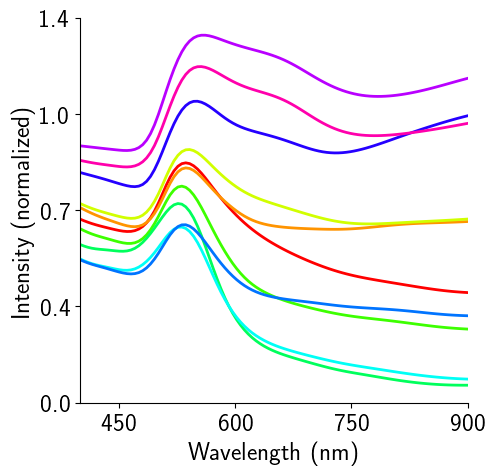

In [44]:
from matplotlib import colors

def plot_along_line(ax):
    # cmap = colors.LinearSegmentedColormap.from_list('line_cont_cmap', 
    #                                         [(0,    color_blindf[2]),
    #                                         (0.25, color_blindf[1]),
    #                                         (1,    color_blindf[0])], 
    #                                         N=10
    #                                         )
    cmap = plt.get_cmap("hsv")
    norm = Normalize(vmin=0, vmax = 10)
    ax.set_xlim([400.0, 900.0])
    for i in range(10):
        ax.plot(expt.wl, line_spectra[i,:], color=cmap(norm(i)), lw=2.0)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(4))
    ax.yaxis.set_major_locator(ticker.LinearLocator(5))
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.set_xlabel("Wavelength (nm)")
    ax.set_ylabel("Intensity (normalized)")

    return ax

with plt.style.context(pyplot_style):
    fig, ax = plt.subplots(figsize=(5,5))
    plot_along_line(ax)
    if SAVE_FIGS:
        plt.savefig("./figures/linesample.png")
    plt.show()
    

/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_1392/422615921.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(conc_labels)


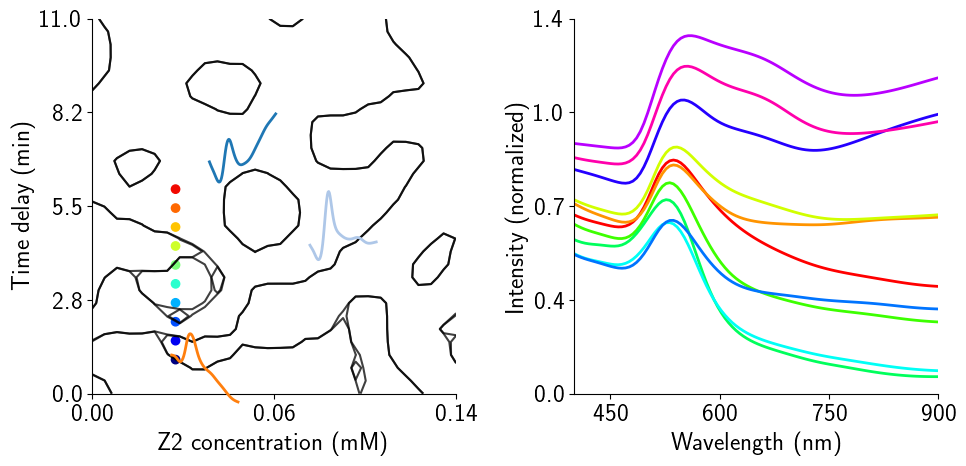

In [45]:
with plt.style.context(pyplot_style):
    fig, axs = plt.subplots(1,2, figsize=(5*2, 5*1))
    plot_phasemap(axs[0])
    cmap = plt.get_cmap("jet")
    norm = Normalize(vmin=0, vmax = 10)
    axs[0].scatter(line_comps[:,0], line_comps[:,1], c = np.arange(10), cmap=cmap, norm=norm)
    plot_along_line(axs[1])
    plt.tight_layout()
    if SAVE_FIGS:
        plt.savefig("./figures/phasemap_and_linesample.png")
    plt.show()


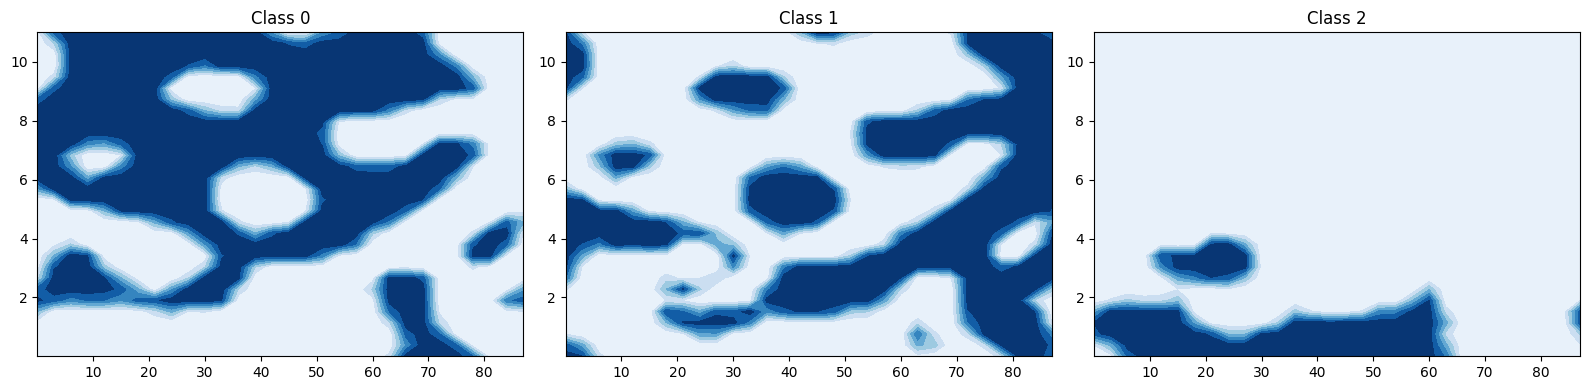

In [46]:
cmap = colormaps["Blues"]
norm = Normalize(vmin=0, vmax = 1)

fig, axs = plt.subplots(1, n_clusters, figsize = (4*4, 4*1))
axs = axs.flatten()
# fig.subplots_adjust(wspace=0.2)
for i in range(n_clusters):
    im = axs[i].contourf(test_x_mat.numpy(), 
                         test_y_mat.numpy(), 
                         probabilities[i].numpy().reshape((n_grid_points,n_grid_points)),
                         cmap=cmap, norm=norm
                         )
    axs[i].set_title("Class " + str(i))

plt.tight_layout()
plt.show()